In [277]:
import koreanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.tree as tree

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

In [278]:
# 데이터 불러오기

df = pd.read_csv('../data/BankChurners.csv')

# drop 컬럼
df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

# 컬럼명 변경
df.columns = ['Exited', 'Age', 'Gender', 'Dependents', 'Education', 'Marital', 'Income', 'Card_Type',
              'Tenure', 'Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Credit_Limit','Revolv_Bal', 'Avg_OTB', 'Amt_Chng_Q4_Q1',
              'Trans_Amt', 'Trans_Cnt', 'Cnt_Chng_Q4_Q1', 'Avg_Util_Ratio']

# 컬럼 순서 변경
df = df[['Exited', 'Age', 'Gender', 'Dependents', 'Education', 'Marital', 'Income', 'Card_Type',
         'Tenure', 'Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Credit_Limit','Revolv_Bal', 'Avg_OTB',
         'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1', 'Cnt_Chng_Q4_Q1']]

df_eda3 = df

# 1. EDA

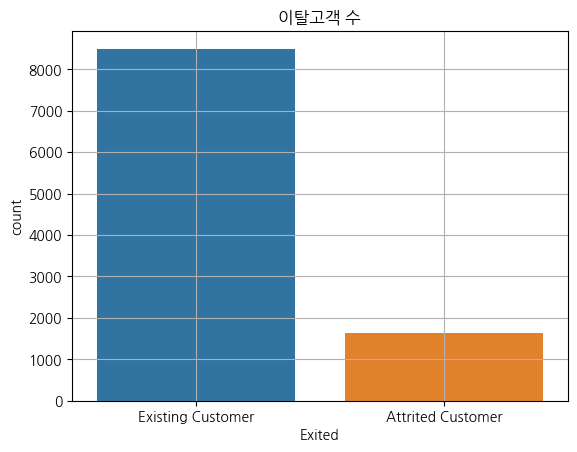

In [279]:
# 이탈고객 수
sns.countplot(data=df_eda3, x='Exited')
plt.title('이탈고객 수')
plt.grid()
plt.show();

### Contacts_Cnt

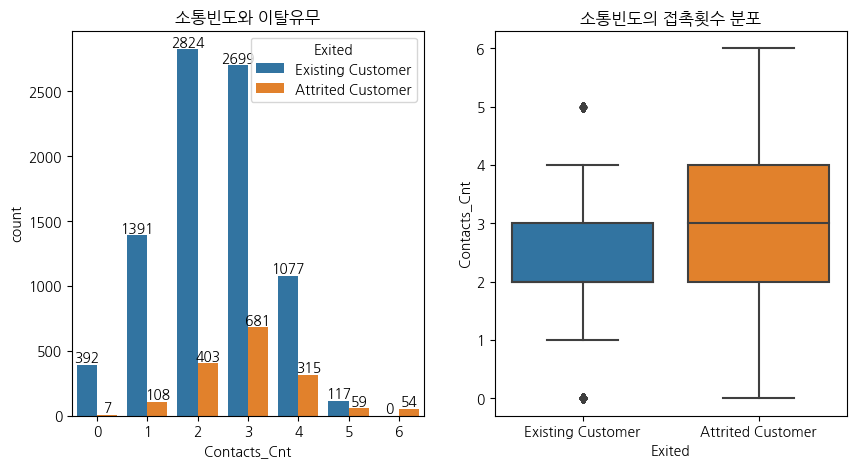

In [280]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.countplot(x='Contacts_Cnt', hue='Exited', data=df_eda3, ax= ax[0])
for label in ax1.containers:
    ax1.bar_label(label)
ax1.set_title('소통빈도와 이탈유무')
ax2 = sns.boxplot(data=df_eda3, y= 'Contacts_Cnt', x= 'Exited', ax= ax[1])
ax2.set_title('소통빈도의 접촉횟수 분포')
plt.show();

- 접촉횟수가 4번인 고객은 1/4 정도가 이탈
- 접촉횟수가 5번인 고객의 1/3 정도가 이탈
- 접촉횟수가 6번인 고객은 전부 이탈
- 접촉횟수가 증가할수록 이탈 비율이 커진다.

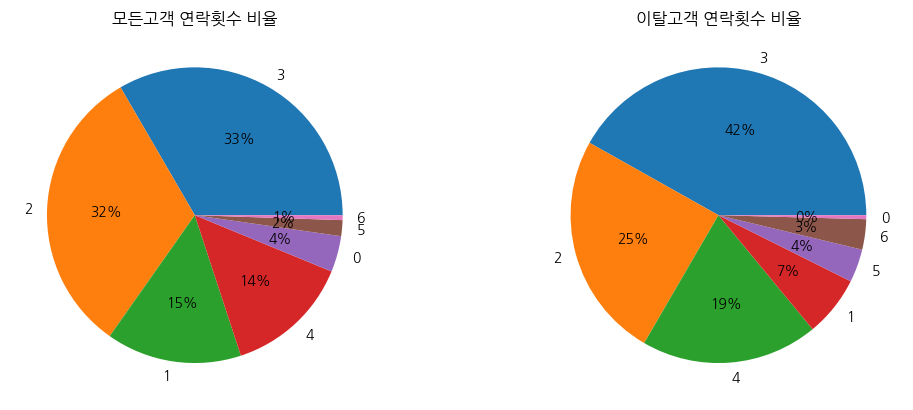

In [281]:
plt.subplot(1,2,1)
data_counts = df_eda3['Contacts_Cnt'].value_counts()
labels = data_counts.index
counts = data_counts.values
plt.pie(counts, labels=labels,autopct='%.0f%%')
plt.title("모든고객 연락횟수 비율")

plt.subplot(1,2,2)
data_counts = df_eda3[df_eda3['Exited']== 'Attrited Customer']['Contacts_Cnt'].value_counts()
labels = data_counts.index
counts = data_counts.values
plt.pie(counts, labels=labels,autopct='%.0f%%')
plt.title("이탈고객 연락횟수 비율")

plt.subplots_adjust(left = 0.5, right = 2)

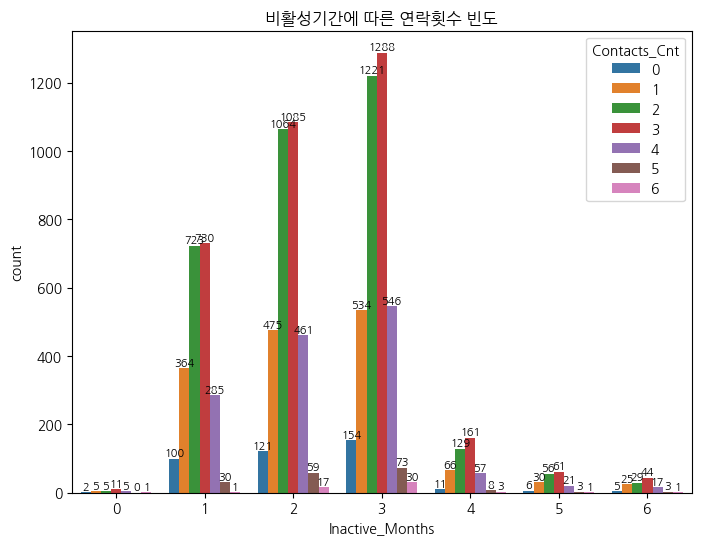

In [282]:
# 비활성기간에 따른 연락횟수 빈도

plt.figure(figsize=(8, 6))
ax1 = sns.countplot(x='Inactive_Months', hue='Contacts_Cnt', data=df_eda3)
for label in ax1.containers:
    ax1.bar_label(label, fontsize=8)
ax1.set_title('비활성기간에 따른 연락횟수 빈도')
plt.show()

- 비활성기간에 상관없이 연락횟수는 보통 2~3번 정도이다.
- 비활성기간에 따른 연락횟수는 정규분포를 이룬다고 봐도 될 것 같다.

### Credit_Limit

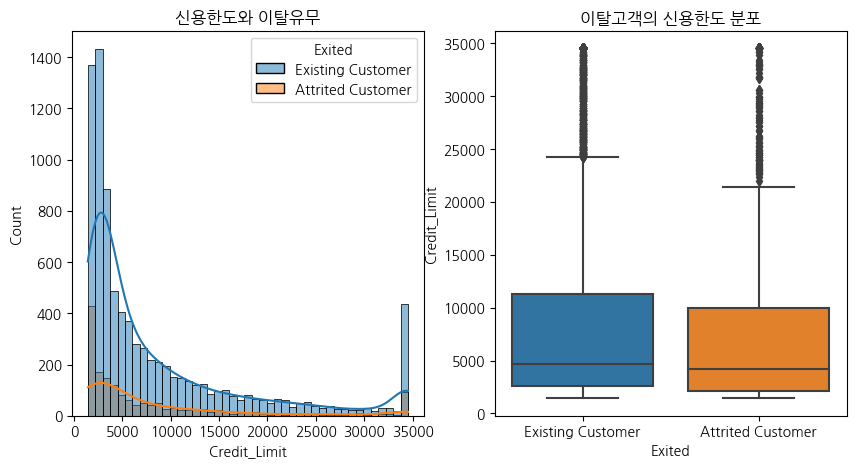

In [283]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(x='Credit_Limit', data=df_eda3, hue='Exited', ax=ax[0], kde=True)
ax1.set_title('신용한도와 이탈유무')

ax2 = sns.boxplot(data= df_eda3, y='Credit_Limit', x= 'Exited', ax= ax[1])
ax2.set_title('이탈고객의 신용한도 분포')
plt.show()

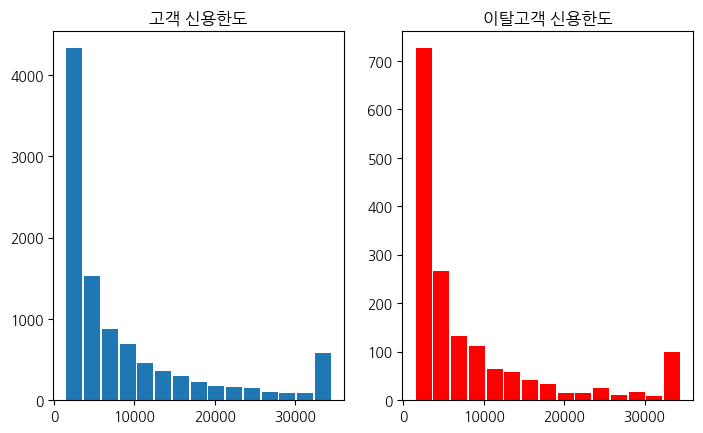

In [284]:
plt.subplot(1,2,1)
plt.hist(df_eda3['Credit_Limit'], rwidth = 0.9, bins = 15)
plt.title('고객 신용한도')

plt.subplot(1,2,2)
plt.hist(df_eda3[df_eda3['Exited']== 'Attrited Customer']['Credit_Limit'], rwidth = 0.9, color = 'r', bins = 15)
plt.title('이탈고객 신용한도')

plt.subplots_adjust(left = 1, right = 2)

- 전체 고객과 이탈고객의 신용한도는 비슷한 분포를 보인다.

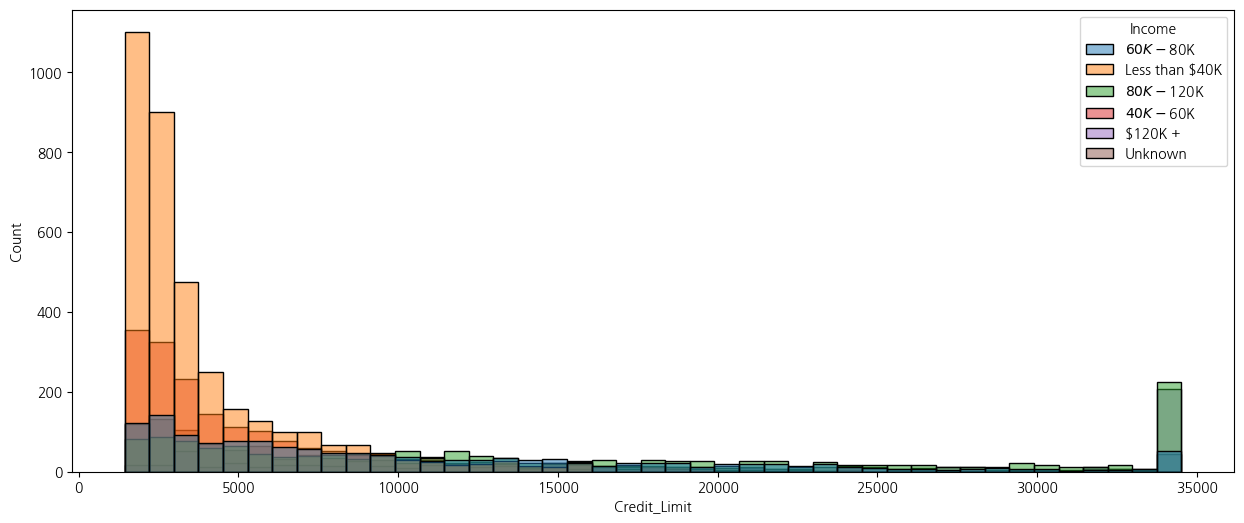

In [285]:
plt.figure(figsize=(15,6))              
sns.histplot(x='Credit_Limit', data=df_eda3, hue='Income')
plt.show();

- 신용한도가 낮을수록 수입이 적어 보이고, 신용한도가 높을수록 수입이 더 많다.

### Revolv_Bal

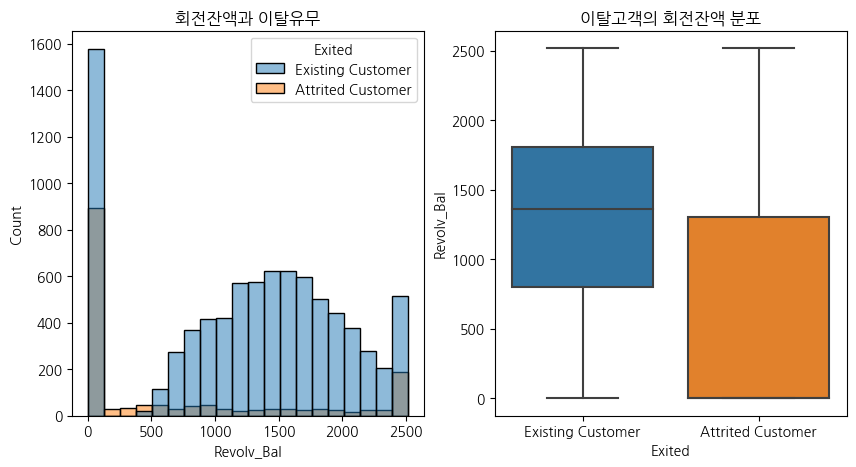

In [286]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(x='Revolv_Bal', data=df_eda3, hue='Exited', ax=ax[0])
ax1.set_title('회전잔액과 이탈유무')

ax2 = sns.boxplot(data=df_eda3, y='Revolv_Bal', x= 'Exited', ax= ax[1])
ax2.set_title('이탈고객의 회전잔액 분포')
plt.show()

- 회전잔액이 0이면 절반정도가 이탈
- 회전잔액이 0~500사이면 이탈하는 고객이 많다.
- 회전잔액이 2500부근에선 약 30% 고객이 이탈

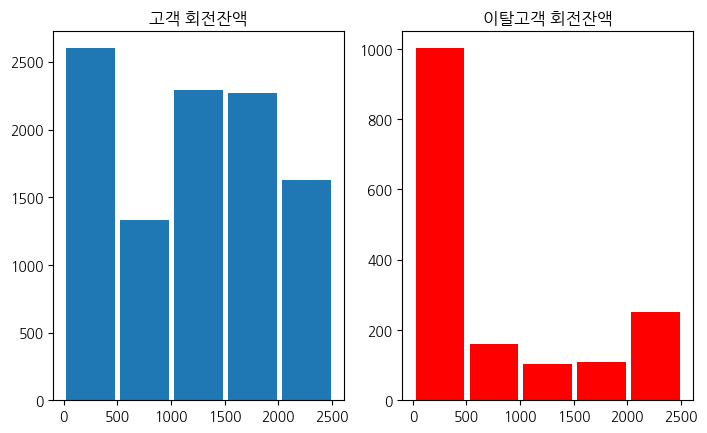

In [287]:
plt.subplot(1,2,1)
plt.hist(df_eda3['Revolv_Bal'], rwidth = 0.9, bins = 5)
plt.title('고객 회전잔액')

plt.subplot(1,2,2)
plt.hist(df_eda3[df_eda3['Exited']== 'Attrited Customer']['Revolv_Bal'], rwidth = 0.9, color = 'r', bins = 5)
plt.title('이탈고객 회전잔액')

plt.subplots_adjust(left = 1, right = 2)

### Avg_OTB

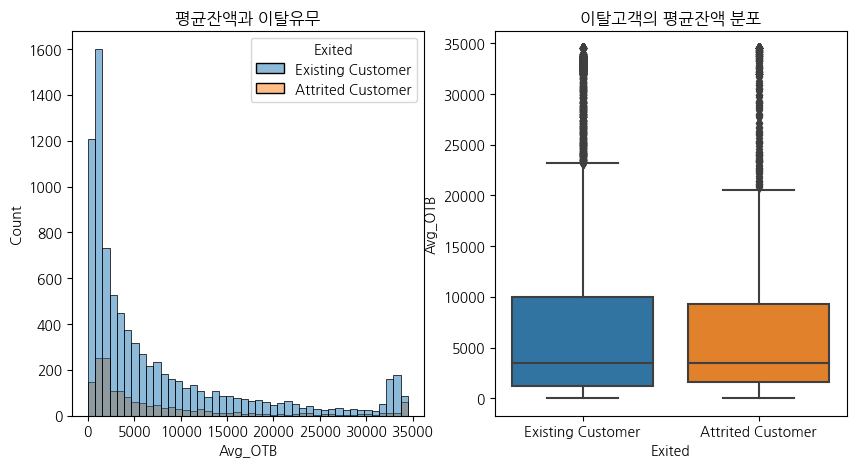

In [288]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(x='Avg_OTB', data=df_eda3, hue='Exited', ax=ax[0])
ax1.set_title('평균잔액과 이탈유무')

ax2 = sns.boxplot(data=df_eda3, y='Avg_OTB', x= 'Exited', ax= ax[1])
ax2.set_title('이탈고객의 평균잔액 분포')
plt.show()

- 평균잔액 3000 정도에서 약 30%의 이탈률
- 평균잔액 34000 정도에서 높은 이탈률

# 라벨링

In [289]:
# 라벨링
exited = {'Existing Customer': 0, 'Attrited Customer':1}
gender = {'M':0, 'F':1}
education = {'Uneducated': 0, 'High School':1, 'College':2, 'Graduate':3, 'Post-Graduate': 4, 'Doctorate':5, 'Unknown':6}
marital = {'Single':0, 'Married': 1, 'Divorced':2, 'Unknown':3}
income = {'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +':4, 'Unknown':5}
card = {'Blue':0, 'Silver':1 , 'Gold': 2, 'Platinum': 3}
df_eda3['Exited'] = df_eda3['Exited'].map(exited)
df_eda3['Gender'] = df_eda3['Gender'].map(gender)
df_eda3['Education'] = df_eda3['Education'].map(education)
df_eda3['Marital'] = df_eda3['Marital'].map(marital)
df_eda3['Income'] = df_eda3['Income'].map(income)
df_eda3['Card_Type'] = df_eda3['Card_Type'].map(card)
df.head()

,Exited,Age,Gender,Dependents,Education,Marital,Income,Card_Type,Tenure,Product_Cnt,Inactive_Months,Contacts_Cnt,Credit_Limit,Revolv_Bal,Avg_OTB,Avg_Util_Ratio,Trans_Amt,Trans_Cnt,Amt_Chng_Q4_Q1,Cnt_Chng_Q4_Q1
0,0,45,0,3,1,1,2,0,39,5,1,3,12691.0,777,11914.0,0.061,1144,42,1.335,1.625
1,0,49,1,5,3,0,0,0,44,6,1,2,8256.0,864,7392.0,0.105,1291,33,1.541,3.714
2,0,51,0,3,3,1,3,0,36,4,1,0,3418.0,0,3418.0,0.000,1887,20,2.594,2.333
3,0,40,1,4,1,3,0,0,34,3,4,1,3313.0,2517,796.0,0.760,1171,20,1.405,2.333
4,0,40,0,3,0,1,2,0,21,5,1,0,4716.0,0,4716.0,0.000,816,28,2.175,2.500


In [290]:
X = df_eda3[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1','Cnt_Chng_Q4_Q1']]
y = df_eda3['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

# 하이파라미터 

In [291]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
estimators = [
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(solver='liblinear', random_state=13))
]
pipe = Pipeline(estimators)

# 탐색할 하이퍼파라미터들의 후보 값들
params = {
    'lr__C': [0.05, 0.1, 0.3, 0.5],  # C 값 후보
    'lr__penalty': ['l1', 'l2'],  # L1 정규화 또는 L2 정규화 후보
}

GridSearch = GridSearchCV(estimator=pipe, param_grid=params, cv=skf)
GridSearch.fit(X_train, y_train)

best = GridSearch.best_estimator_
pred = best.predict(X_test)

# best parameter
print(GridSearch.best_params_)

# 모델 평가 지표
print('Accuracy: ', accuracy_score(y_test, pred))
print('Precision: ', precision_score(y_test, pred))
print('Recall: ', recall_score(y_test, pred))
print('F1: ', f1_score(y_test, pred))
print('Roc-auc: ', roc_auc_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

{'lr__C': 0.05, 'lr__penalty': 'l2'}
Accuracy:  0.8993089832181639
Precision:  0.7510373443983402
Recall:  0.556923076923077
F1:  0.6395759717314488
Roc-auc:  0.7608248541581876
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1701
           1       0.75      0.56      0.64       325

    accuracy                           0.90      2026
   macro avg       0.84      0.76      0.79      2026
weighted avg       0.89      0.90      0.89      2026

[[1641   60]
 [ 144  181]]


In [292]:
score_df = pd.DataFrame(GridSearch.cv_results_)
score_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

,params,rank_test_score,mean_test_score,std_test_score
0,"{'lr__C': 0.05, 'lr__penalty': 'l1'}",6,0.897914,0.005657
1,"{'lr__C': 0.05, 'lr__penalty': 'l2'}",1,0.898284,0.005007
2,"{'lr__C': 0.1, 'lr__penalty': 'l1'}",5,0.897914,0.004763
3,"{'lr__C': 0.1, 'lr__penalty': 'l2'}",1,0.898284,0.004773
4,"{'lr__C': 0.3, 'lr__penalty': 'l1'}",3,0.898037,0.004898
5,"{'lr__C': 0.3, 'lr__penalty': 'l2'}",8,0.897667,0.004992
6,"{'lr__C': 0.5, 'lr__penalty': 'l1'}",4,0.897914,0.004288
7,"{'lr__C': 0.5, 'lr__penalty': 'l2'}",7,0.897790,0.004396


# OverSampling

In [293]:
features = X.values
label = y.values

# 스케일링
std = StandardScaler()
features_scaled = std.fit_transform(features)

# 데이터 나누기
X_train2, X_test, y_train2, y_test = train_test_split(features_scaled, label,
                                                    test_size=0.2,
                                                    stratify=label,
                                                    random_state=13)

# SMOTE 오버샘플링
smote = SMOTE(random_state=13)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train2, y_train2)

# 최적의 하이퍼파라미터로 XGBoost 모델 생성
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=0,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.7
)

model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [294]:
# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)[:, 1]

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 정밀도 평가
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# 재현율 평가
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1-score 평가
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# AUC-ROC 평가
roc_auc = roc_auc_score(y_test, y_pred_probs)
print("AUC-ROC:", roc_auc)


Accuracy: 0.9619940769990128
Precision: 0.8463687150837989
Recall: 0.9323076923076923
F1-score: 0.8872620790629575
AUC-ROC: 0.9899190521412742


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1701
           1       0.85      0.93      0.89       325

    accuracy                           0.96      2026
   macro avg       0.92      0.95      0.93      2026
weighted avg       0.96      0.96      0.96      2026



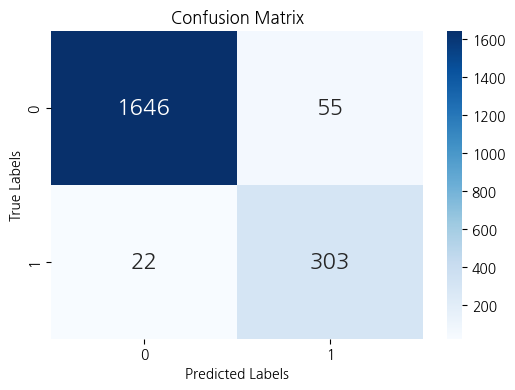

In [296]:
# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

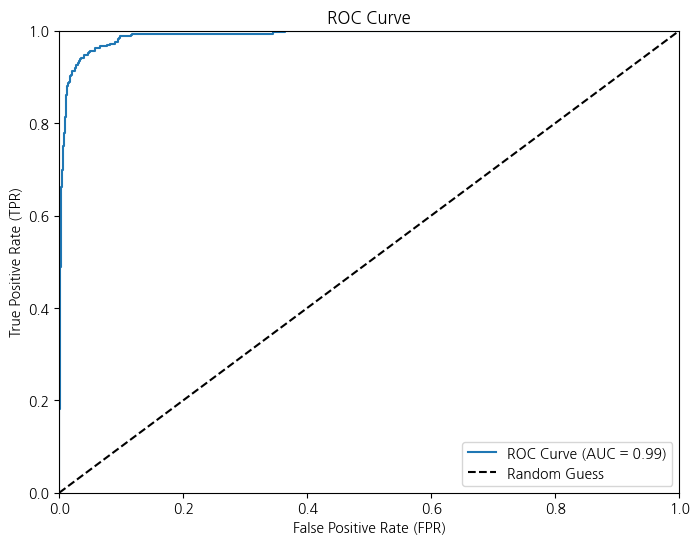

In [297]:
# 테스트 데이터로 예측 수행
y_pred_probs = model.predict_proba(X_test)[:, 1]

# ROC curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# ROC curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_probs)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [298]:
# specificity / negative predictive value
cm = confusion_matrix(y_test, y_pred)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

specificity = TN / (TN + FP)
npv = TN / (TN + FN)

print('specificity : ', specificity)
print('npv : ', npv)

specificity :  0.9676660787771899
npv :  0.986810551558753
